In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [3]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [4]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [5]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [6]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x, y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [7]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x, y in dataset:
    print(x.numpy(), y.numpy())

[4 5 6 7] [8]
[5 6 7 8] [9]
[0 1 2 3] [4]
[2 3 4 5] [6]
[3 4 5 6] [7]
[1 2 3 4] [5]


In [8]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x, y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[5 6 7 8]
 [2 3 4 5]]
y =  [[9]
 [6]]
x =  [[1 2 3 4]
 [4 5 6 7]]
y =  [[5]
 [8]]
x =  [[0 1 2 3]
 [3 4 5 6]]
y =  [[4]
 [7]]


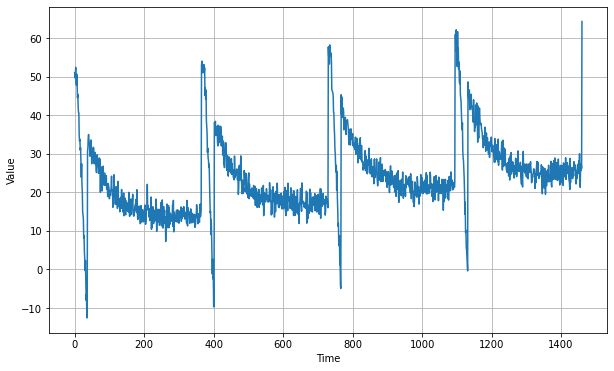

In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [11]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_validation = time[split_time:]
x_validation = series[split_time:]

In [27]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, input_shape=[window_size]),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 512)               10752     
                                                                 
 dense_20 (Dense)            (None, 256)               131328    
                                                                 
 dense_21 (Dense)            (None, 1)                 257       
                                                                 
Total params: 142,337
Trainable params: 142,337
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(dataset, epochs=150)

Epoch 1/150
46/46 [==============================] - 0s 2ms/step - loss: 178.8140
Epoch 2/150
46/46 [==============================] - 0s 2ms/step - loss: 36.0978
Epoch 3/150
46/46 [==============================] - 0s 2ms/step - loss: 27.6184
Epoch 4/150
46/46 [==============================] - 0s 2ms/step - loss: 24.4109
Epoch 5/150
46/46 [==============================] - 0s 2ms/step - loss: 22.6318
Epoch 6/150
46/46 [==============================] - 0s 2ms/step - loss: 21.3521
Epoch 7/150
46/46 [==============================] - 0s 2ms/step - loss: 20.5042
Epoch 8/150
46/46 [==============================] - 0s 2ms/step - loss: 19.9125
Epoch 9/150
46/46 [==============================] - 0s 2ms/step - loss: 19.2860
Epoch 10/150
46/46 [==============================] - 0s 2ms/step - loss: 20.4671
Epoch 11/150
46/46 [==============================] - 0s 2ms/step - loss: 20.5559
Epoch 12/150
46/46 [==============================] - 0s 2ms/step - loss: 17.6761
Epoch 13/150
46/46 [====